## notebook testing blob radius extraction ideas

Need a metric to quantify its success

In [1]:
import sys,os,os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io             import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io            import hits_from_df
from invisible_cities.reco                  import paolina_functions as plf
from invisible_cities.types.ic_types        import         types_dict_tracks
from invisible_cities.types.symbols         import                 HitEnergy
from invisible_cities.evm.event_model       import             HitCollection
from invisible_cities.core                  import system_of_units as units

from typing import Tuple, Callable

import core.plotting_functions as plt_func


# preset parameters

In [ ]:
# Do you only want one track?
one_track = True

# What data do you want to look at?
#path = '../data/MC/'
path = '../data/CLEAN/'

## lets create the blob info creator extractor from scratch

In [14]:
# output the accuracy of the blob positions
def output_inaccuracy(df, df_MC):

    RECO_b1_xyz = np.column_stack([df.blob1_x[0], df.blob1_y[0], df.blob1_z[0]])
    RECO_b2_xyz = np.column_stack([df.blob2_x[0], df.blob2_y[0], df.blob2_z[0]])

    MC_b1_xyz = np.column_stack([df_MC.blob1_x[0], df_MC.blob1_y[0], df_MC.blob1_z[0]])
    MC_b2_xyz = np.column_stack([df_MC.blob2_x[0], df_MC.blob2_y[0], df_MC.blob2_z[0]])


    dist_b1 = np.linalg.norm((RECO_b1_xyz) - (MC_b1_xyz))
    dist_b2 = np.linalg.norm((RECO_b2_xyz) - (MC_b2_xyz))
    print(f"Blob 1 RECO/MC distance: {dist_b1:.2f}mm")
    print(f"Blob 2 RECO/MC distance: {dist_b2:.2f}mm")

    print('=' * 20)
    print('Assuming blobs flipped: ')
    dist_b1_flip = np.linalg.norm((RECO_b2_xyz) - (MC_b1_xyz))
    dist_b2_flip = np.linalg.norm((RECO_b1_xyz) - (MC_b2_xyz))
    print(f"Blob 1 RECO/ Blob 2 MC distance: {dist_b1_flip:.2f}mm")
    print(f"Blob 2 RECO/ Blob 1 MC distance: {dist_b2_flip:.2f}mm")



def track_blob_info_creator_extractor(vox_size         : Tuple[float, float, float],
                                      strict_vox_size  : bool                      ,
                                      energy_threshold : float                     ,
                                      min_voxels       : int                       ,
                                      blob_radius      : float                     ,
                                      max_num_hits     : int
                                     ) -> Callable:
    """
    For a given paolina parameters returns a function that extract tracks / blob information from a HitCollection.

    Parameters
    ----------
    vox_size         : [float, float, float]
        (maximum) size of voxels for track reconstruction
    strict_vox_size  : bool
        if False allows per event adaptive voxel size,
        smaller of equal thatn vox_size
    energy_threshold : float
        if energy of end-point voxel is smaller
        the voxel will be dropped and energy redistributed to the neighbours
    min_voxels       : int
        after min_voxel number of voxels is reached no dropping will happen.
    blob_radius      : float
        radius of blob

    Returns
    ----------
    A function that from a given HitCollection returns a pandas DataFrame with per track information.
    """
    def create_extract_track_blob_info(hitc):
        df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
        if len(hitc.hits) > max_num_hits:
            return df, hitc, True
        #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
        track_hitc = HitCollection(hitc.event, hitc.time)
        out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
        if out_of_map:
            #add nan hits to track_hits, the track_id will be -1
            track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
            hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
            #create new Hitcollection object but keep the name hitc
            hitc      = HitCollection(hitc.event, hitc.time)
            hitc.hits = hits_without_nan

        hit_energies = np.array([getattr(h, HitEnergy.Ep.value) for h in hitc.hits])

        if len(hitc.hits) > 0 and (hit_energies>0).any():
            voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, HitEnergy.Ep)
            (    mod_voxels,
             dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)

            for v in dropped_voxels:
                track_hitc.hits.extend(v.hits)

            tracks = plf.make_track_graphs(mod_voxels)
            tracks = sorted(tracks, key=plf.get_track_energy, reverse=True)

            vox_size_x = voxels[0].size[0]
            vox_size_y = voxels[0].size[1]
            vox_size_z = voxels[0].size[2]
            del(voxels)

            track_hits = []
            for c, t in enumerate(tracks, 0):
                tID = c
                energy = plf.get_track_energy(t)
                numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
                numb_of_voxels = len(t.nodes())
                numb_of_tracks = len(tracks   )
                pos   = [h.pos for v in t.nodes() for h in v.hits]
                x, y, z = map(np.array, zip(*pos))
                r = np.sqrt(x**2 + y**2)

                e     = [h.Ep for v in t.nodes() for h in v.hits]
                ave_pos = np.average(pos, weights=e, axis=0)
                ave_r   = np.average(r  , weights=e, axis=0)
                distances = plf.shortest_paths(t)
                extr1, extr2, length = plf.find_extrema_and_length(distances)
                extr1_pos = extr1.XYZ
                extr2_pos = extr2.XYZ

                e_blob1, e_blob2, hits_blob1, hits_blob2, blob_pos1, blob_pos2 = plf.blob_energies_hits_and_centres(t, blob_radius)

                overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
                list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
                                numb_of_hits, numb_of_tracks,
                                min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
                                *ave_pos, ave_r, *extr1_pos,
                                *extr2_pos, *blob_pos1, *blob_pos2,
                                e_blob1, e_blob2, overlap,
                                vox_size_x, vox_size_y, vox_size_z]

                df.loc[c] = list_of_vars

                for vox in t.nodes():
                    for hit in vox.hits:
                        hit.track_id = tID
                        track_hits.append(hit)

            #change dtype of columns to match type of variables
            df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
            track_hitc.hits.extend(track_hits)
        return df, track_hitc, out_of_map

    return create_extract_track_blob_info


## load in data

In [ ]:

# find .h5 files in path
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.h5')]
RECO_hits = load_dst(f'{files[0]}', 'RECO', 'Events')
MC_hits = load_dst(f'{files[0]}', 'MC', 'hits')
part_info = load_dst(f'{files[0]}', 'MC', 'particles')
# particle data too

display(RECO_hits)
display(MC_hits)
display(part_info)


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,12300000,2.460000e+13,0,317.485685,85.823177,1,335.525,168.675,0.0,0.0,499.824461,5.043478,380.105596,-1.0,0.001002,-1,-1.0
1,12300000,2.460000e+13,0,317.485685,85.823177,1,335.525,184.225,0.0,0.0,499.824461,6.782609,511.176490,-1.0,0.001367,-1,-1.0
2,12300000,2.460000e+13,0,317.485685,85.823177,1,351.075,168.675,0.0,0.0,499.824461,6.144928,463.117140,-1.0,0.001255,-1,-1.0
3,12300000,2.460000e+13,0,317.485685,85.823177,1,351.075,184.225,0.0,0.0,499.824461,9.043478,681.568606,-1.0,0.001880,-1,-1.0
4,12300000,2.460000e+13,0,317.485685,85.823177,1,366.625,184.225,0.0,0.0,499.824461,5.333333,401.950703,-1.0,0.001122,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105426,12300111,2.460022e+13,0,84.976778,171.699804,1,57.625,199.275,0.0,0.0,944.505386,5.797101,635.478793,-1.0,0.001589,-1,-1.0
105427,12300111,2.460022e+13,0,84.976778,171.699804,1,57.625,214.825,0.0,0.0,944.505386,7.014493,768.929359,-1.0,0.001932,-1,-1.0
105428,12300111,2.460022e+13,0,84.976778,171.699804,1,57.625,230.375,0.0,0.0,944.505386,6.260870,686.317084,-1.0,0.001742,-1,-1.0
105429,12300111,2.460022e+13,0,84.976778,171.699804,1,73.175,199.275,0.0,0.0,944.505386,10.434782,1143.861754,-1.0,0.002863,-1,-1.0


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,12300000,39,0,352.022552,248.544846,508.099854,0.566156,0.000154,ACTIVE
1,12300000,46,0,352.022736,248.544662,508.099945,0.566252,0.000021,ACTIVE
2,12300000,45,0,352.022461,248.544876,508.099915,0.566188,0.000034,ACTIVE
3,12300000,44,0,352.022552,248.545090,508.099792,0.566248,0.000023,ACTIVE
4,12300000,43,0,352.022614,248.544830,508.099670,0.566254,0.000010,ACTIVE
...,...,...,...,...,...,...,...,...,...
122354,12300111,85912,0,110.963722,157.122604,892.937317,2.164472,0.000058,ACTIVE
122355,12300111,85912,1,110.964897,157.121750,892.936951,2.164562,0.000797,ACTIVE
122356,12300111,21,177,110.730919,157.186722,892.950134,2.163740,0.000012,ACTIVE
122357,12300111,21,178,110.725800,157.184143,892.950134,2.163915,0.001172,ACTIVE


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,12300000,1,Tl208,True,0,398.527893,401.795593,563.769714,0.000000,398.527893,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,12300000,4,e-,False,1,398.527893,401.795593,563.769714,0.000593,398.723450,...,0.866598,-1.133614,0.059521,0.000000,-0.000000,-0.000000,1.005819,0.721643,RadioactiveDecay,NoProcess
2,12300000,3,anti_nu_e,False,1,398.527893,401.795593,563.769714,0.000593,8578.574219,...,0.263275,0.149004,-0.420457,0.263275,0.149004,-0.420457,0.517977,16093.740234,RadioactiveDecay,Transportation
3,12300000,2,Pb208[3475.078],False,1,398.527893,401.795593,563.769714,0.000593,398.527893,...,-1.129872,0.984610,0.360936,-0.000000,0.000000,0.000000,0.000006,0.000000,RadioactiveDecay,RadioactiveDecay
4,12300000,6,gamma,False,2,398.527893,401.795593,563.769714,0.000593,419.103455,...,0.338387,0.497161,0.615531,0.000000,-0.000000,0.000000,0.860554,67.016731,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,12300111,85914,e-,False,85878,110.963333,157.122894,892.937439,2.164443,110.962929,...,-0.005660,-0.007120,0.018418,-0.000000,-0.000000,-0.000000,0.000413,0.002709,phot,NoProcess
10685,12300111,85913,e-,False,85878,110.963333,157.122894,892.937439,2.164443,110.963226,...,-0.000222,0.011726,0.001835,-0.000000,-0.000000,-0.000000,0.000138,0.001273,phot,NoProcess
10686,12300111,85912,e-,False,85878,110.963333,157.122894,892.937439,2.164443,110.964897,...,0.022998,-0.016937,-0.007630,0.000000,-0.000000,-0.000000,0.000854,0.006689,phot,NoProcess
10687,12300111,21,e-,False,20,109.059830,176.973953,873.465942,1.599184,110.724388,...,-0.780822,-0.286674,0.291805,-0.000000,0.000000,0.000000,0.507890,123.451622,conv,NoProcess


## select event, and check it

In [5]:
# select event
n = 100

MC_evt   = MC_hits[MC_hits.event_id     == MC_hits.event_id.unique()[n]]
RECO_evt = RECO_hits[RECO_hits.event    == RECO_hits.event.unique()[n]]
prt_evt  = part_info[part_info.event_id == part_info.event_id.unique()[n]]

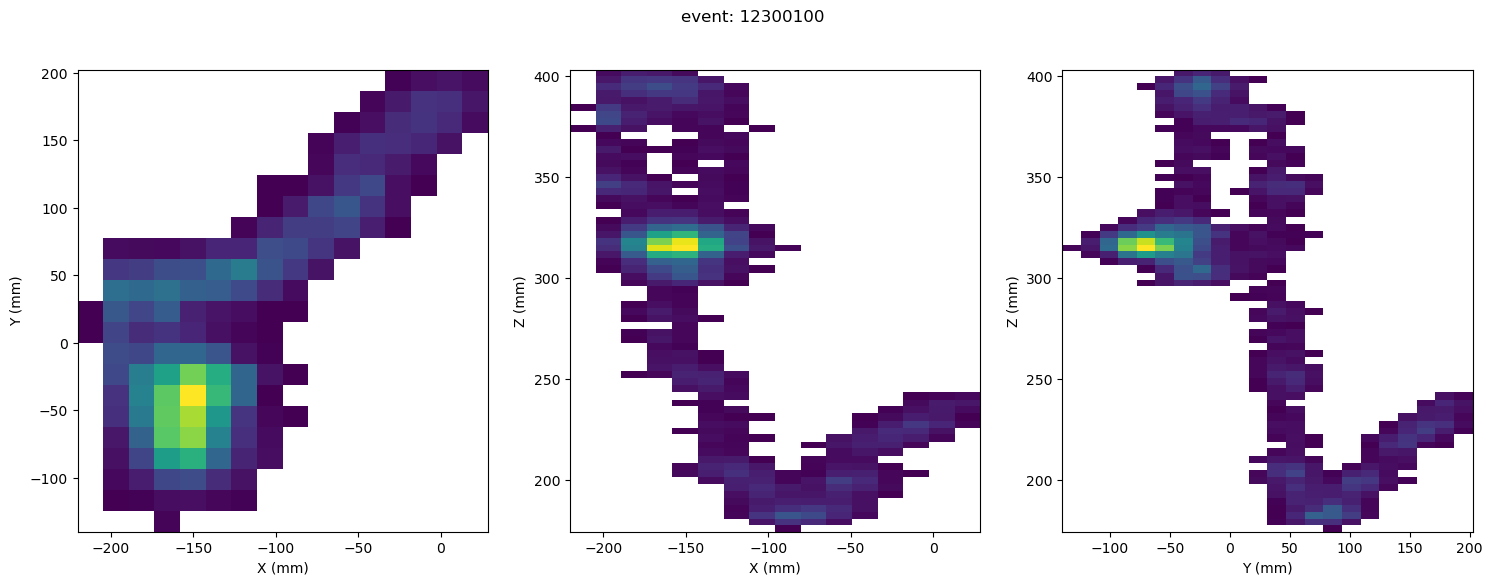

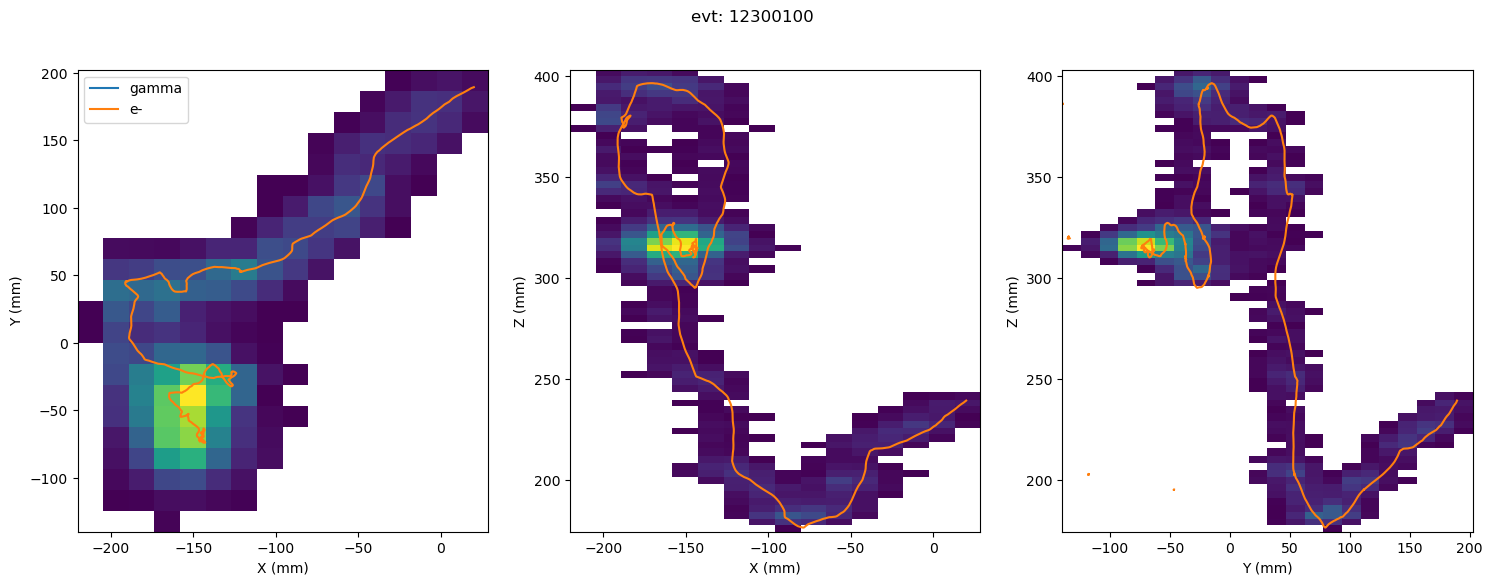

In [6]:
# display event
plt_func.raw_plotter(RECO_evt, RECO_evt.event.unique()[0])
#plt_func.raw_plotter(MC_evt, MC_evt.event_id.unique()[0], MC = True)
plt_func.plot_MC_over_hits(RECO_evt, MC_evt, prt_evt, MC_evt.event_id.unique()[0])

## set up topology extraction

Both:
- MC hits (small voxelisation)
- RECO hits (larger voxelisation)

In [7]:
voxel_size_RECO       = 18 * units.mm
blob_radius_RECO      = 45 * units.mm
scan_radius_RECO      = 60 * units.mm

voxel_size_MC         = 1  * units.mm
blob_radius_MC        = 27 * units.mm
scan_radius_MC        = 40 * units.mm

# topological creation
topological_creator_RECO = track_blob_info_creator_extractor((voxel_size_RECO, voxel_size_RECO, voxel_size_RECO),
                                                        False,
                                                        0 * units.keV,
                                                        0,
                                                        blob_radius_RECO,
                                                        10000000000,
                                                        #scan_radius = scan_radius_RECO
                                                        )

topological_creator_MC = track_blob_info_creator_extractor((voxel_size_MC, voxel_size_MC, voxel_size_MC),
                                                        False,
                                                        0 * units.keV,
                                                        0,
                                                        blob_radius_MC,
                                                        10000000000,
                                                        #scan_radius = scan_radius_MC
                                                        )

In [8]:
display(MC_evt)
MC_untouched_evt = MC_evt.copy(deep = True)
RECO_untouched_evt = RECO_evt.copy(deep = True)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
109276,12300100,43,0,20.842030,189.675476,239.974472,1.805152,0.000059,ACTIVE
109277,12300100,47,0,20.842196,189.675568,239.974274,1.805233,0.000032,ACTIVE
109278,12300100,46,0,20.842293,189.675583,239.974487,1.805223,0.000047,ACTIVE
109279,12300100,45,0,20.842009,189.675476,239.974472,1.805164,0.000010,ACTIVE
109280,12300100,44,0,20.033955,189.353287,239.481750,1.808553,0.001457,ACTIVE
...,...,...,...,...,...,...,...,...,...
110693,12300100,44,897,-146.222565,-72.630150,315.689667,4.806153,0.001398,ACTIVE
110694,12300100,44,898,-146.222748,-72.628410,315.689117,4.806219,0.000022,ACTIVE
110695,12300100,44,899,-146.222580,-72.627235,315.689056,4.806262,0.000040,ACTIVE
110696,12300100,44,900,-146.225388,-72.628578,315.687653,4.806388,0.000363,ACTIVE


In [9]:
if 'Ec' in RECO_evt.columns:
        RECO_evt['Ep'] = RECO_evt['Ec']
else:
        raise KeyError("RECO_evt does not contain column 'Ec'")

hits_RECO = hits_from_df(RECO_evt)




/tmp/ipykernel_29350/1159503685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RECO_evt['Ep'] = RECO_evt['Ec']


In [10]:

# reshape the MC, this will only work once!
MC_evt.rename(columns={'x': 'X', 'y': 'Y', 'z': 'Z', 'energy': 'E', 'event_id' : 'event'}, inplace=True)
MC_evt['npeak'] = 1
reshaped_hits = MC_evt.rename(columns={'E': 'Ep'}).assign(Q=1)[['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'Ep']]
reshaped_hits['E'] = reshaped_hits.Ep
display(reshaped_hits)

hits_MC   = hits_from_df(reshaped_hits)

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_29350/2464040654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MC_evt['npeak'] = 1


,event,npeak,X,Y,Z,Q,Ep,E
109276,12300100,1,20.842030,189.675476,239.974472,1,0.000059,0.000059
109277,12300100,1,20.842196,189.675568,239.974274,1,0.000032,0.000032
109278,12300100,1,20.842293,189.675583,239.974487,1,0.000047,0.000047
109279,12300100,1,20.842009,189.675476,239.974472,1,0.000010,0.000010
109280,12300100,1,20.033955,189.353287,239.481750,1,0.001457,0.001457
...,...,...,...,...,...,...,...,...
110693,12300100,1,-146.222565,-72.630150,315.689667,1,0.001398,0.001398
110694,12300100,1,-146.222748,-72.628410,315.689117,1,0.000022,0.000022
110695,12300100,1,-146.222580,-72.627235,315.689056,1,0.000040,0.000040
110696,12300100,1,-146.225388,-72.628578,315.687653,1,0.000363,0.000363


In [11]:
# apply topological result.
for evt in hits_RECO.keys():
        df, track_hitc, out_of_map = topological_creator_RECO(hits_RECO[evt])

for evt in hits_MC.keys():
        df_MC, track_hitc_MC, out_of_map_MC = topological_creator_MC(hits_MC[evt])


In [12]:
# one track only?
if one_track:
    df_MC = df_MC.iloc[:1]
    df = df.iloc[:1]



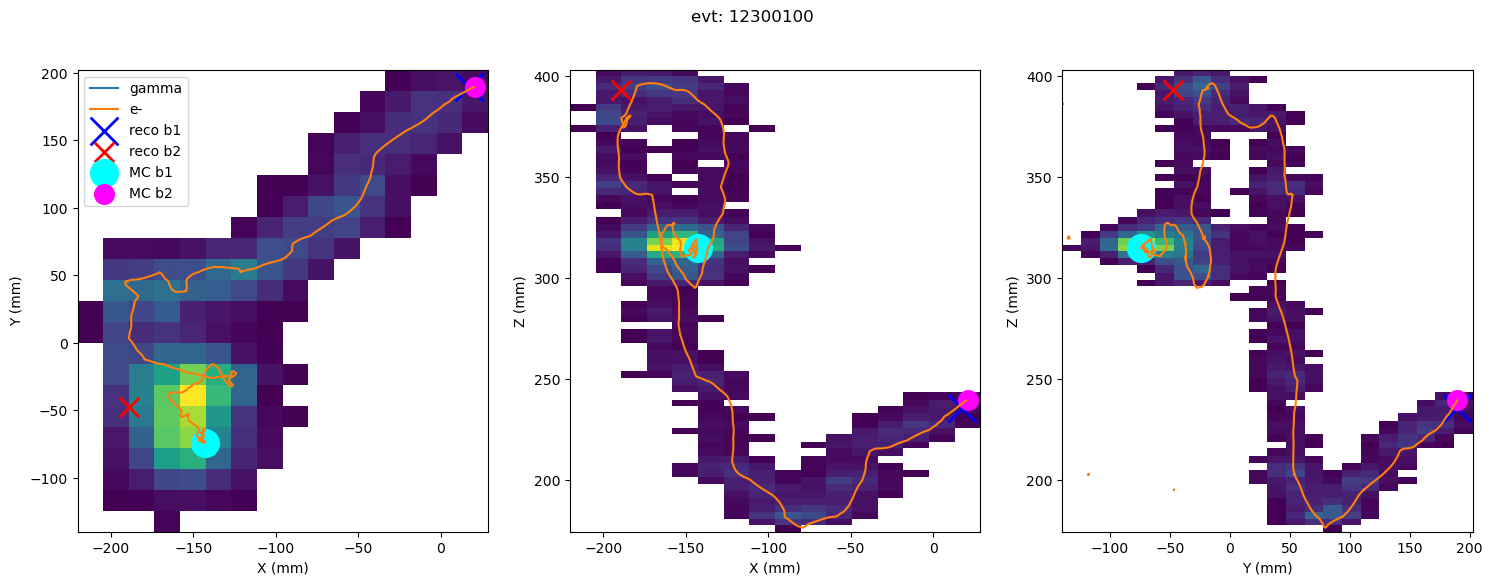

Blob 1 RECO/MC distance: 317.93mm
Blob 2 RECO/MC distance: 351.95mm
Assuming blobs flipped: 
Blob 1 RECO/ Blob 2 MC distance: 94.80mm
Blob 2 RECO/ Blob 1 MC distance: 5.59mm


In [15]:

plt_func.plot_MC_over_hits(RECO_untouched_evt, MC_untouched_evt, prt_evt, MC_untouched_evt.event_id.unique()[0], blob_info = (df, df_MC))
output_inaccuracy(df, df_MC)